# Initialization

In [1]:
import os
from functools import reduce
from typing import Tuple, List
import numpy as np
import math
from PIL import Image
from pyquaternion import Quaternion
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud, Box
from nuscenes.utils.geometry_utils import transform_matrix, BoxVisibility
from nuscenes.utils.color_map import get_colormap
import matplotlib.pyplot as plt

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='./nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.254 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Radar initialize

In [3]:
RADAR_CHAN = ['RADAR_FRONT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 'RADAR_BACK_LEFT', 'RADAR_BACK_RIGHT']
N_SWEEPS = 5
DISABLE_FILTER = False

In [4]:
if DISABLE_FILTER:
    # use all point
    invalid_states = list(range(18))
    dynprop_states = list(range(8))
    ambig_states = list(range(5))
else:
    # use filtered point by invalid states and ambiguity status
    invalid_states = [0, 4, 8, 9, 10, 11, 12, 15, 16, 17]
    dynprop_states = list(range(8))
    ambig_states = [3]

In [5]:
points = np.zeros((18, 0))
all_pc = RadarPointCloud(points)

# Get sample, set reference frame

In [6]:
sample = nusc.sample[20]
sample

{'token': 'c844bf5a9f2243ff8f4bf2c85fe218ff',
 'timestamp': 1532402937698000,
 'prev': 'b26e791522294bec90f86fd72226e35c',
 'next': 'fedfb3a6cb804635a0f47143f9ca8d6f',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': 'e0f3cb9fbae54181945426deed69b4f6',
  'RADAR_FRONT_LEFT': 'a3089ec8a1474912b0036efabf5de2c8',
  'RADAR_FRONT_RIGHT': 'c594463c47074c36acde042dd5a70589',
  'RADAR_BACK_LEFT': 'c721fd748a8c42a7895b1c46f2861689',
  'RADAR_BACK_RIGHT': 'dcb7048f5d07482d8404e904db0fe3ce',
  'LIDAR_TOP': 'e28319b88b634a2d9eff6fdfa7db5500',
  'CAM_FRONT': '06c1523315b14aa7a0dfa4afacafb9e6',
  'CAM_FRONT_RIGHT': '3506e20ade194650955df2c57a69dc21',
  'CAM_BACK_RIGHT': '5e7fa7c26fc04a6fa3358d6dc1e58786',
  'CAM_BACK': '02baa363c8654cf596d30ffce14f5b41',
  'CAM_BACK_LEFT': 'c70904cec6824a4c99bf48ff7973dffb',
  'CAM_FRONT_LEFT': '2a6f34470d6e42808e4eb8e67eedf6a2'},
 'anns': ['f503fa3d050f43cca4af2241b674929a',
  '9593327bd1e64f7da125da9c166f70d4',
  'd37a4132d66f4eec99af9d5

In [7]:
ref_token = sample['data']['LIDAR_TOP']
ref_data = nusc.get('sample_data', ref_token)
ref_data

{'token': 'e28319b88b634a2d9eff6fdfa7db5500',
 'sample_token': 'c844bf5a9f2243ff8f4bf2c85fe218ff',
 'ego_pose_token': 'e28319b88b634a2d9eff6fdfa7db5500',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402937698000,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402937698000.pcd.bin',
 'prev': '7822347b0bd648a888baee831ab174cc',
 'next': '16097043d0674c40b3a92cbfdd2ecc25',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [8]:
ref_pose_rec = nusc.get('ego_pose', ref_data['ego_pose_token'])
ref_time = 1e-6 * ref_data['timestamp']
global_to_ego = transform_matrix(ref_pose_rec['translation'],
                                    Quaternion(ref_pose_rec['rotation']), inverse=True)

# Merge radar sweeps

In [9]:
for chan in RADAR_CHAN:
    # Aggregate current and previous sweeps.
    sample_data_token = sample['data'][chan] # select one radar
    current_sd_rec = nusc.get('sample_data', sample_data_token)
    for sweep in range(N_SWEEPS):
        # Load up the pointcloud and remove points close to the sensor.
        file_name = os.path.join(nusc.dataroot, current_sd_rec['filename'])
        current_pc = RadarPointCloud.from_file(file_name, invalid_states, dynprop_states, ambig_states)

        # Get past pose.
        current_pose_rec = nusc.get('ego_pose', current_sd_rec['ego_pose_token'])
        ego_to_global = transform_matrix(current_pose_rec['translation'],
                                            Quaternion(current_pose_rec['rotation']), inverse=False)

        # Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
        current_cs_rec = nusc.get('calibrated_sensor', current_sd_rec['calibrated_sensor_token'])
        radar_to_ego = transform_matrix(current_cs_rec['translation'], Quaternion(current_cs_rec['rotation']),
                                            inverse=False)

        # TODO: implement ...
        # Fuse three transformation matrices into one and perform transform.
        trans_matrix = reduce(np.dot, [global_to_ego, ..., radar_to_ego])
        # END OF YOUR CODE

        # radar -> ego(past radar timestamp) -> global -> ego(current ref timestamp)
        current_pc.transform(trans_matrix)

        # Add time vector which can be used as a temporal feature.
        time_lag = ref_time - 1e-6 * current_sd_rec['timestamp']  # Positive difference.

        # Rotate velocity to reference frame
        velocities = current_pc.points[8:10, :]  # Compensated velocity
        velocities = np.vstack((velocities, np.zeros(current_pc.points.shape[1])))
        velocities = np.dot(Quaternion(current_cs_rec['rotation']).rotation_matrix, velocities) # radar to ego(past radar timestamp)

        # TODO: implement ...
        velocities = np.dot(Quaternion(...).rotation_matrix, velocities) # ego(past radar timestamp) to global
        # END OF YOUR CODE

        velocities = np.dot(Quaternion(ref_pose_rec['rotation']).rotation_matrix, velocities) # global to ego(current ref timestamp)
        current_pc.points[8:10, :] = velocities[0:2, :]

        # Compensate points on moving object by velocity of point
        current_pc.points[0, :] += current_pc.points[8, :] * time_lag
        current_pc.points[1, :] += current_pc.points[9, :] * time_lag

        # Save sweep index to unused field
        current_pc.points[-1, :] = sweep

        # Merge with key pc.
        all_pc.points = np.hstack((all_pc.points, current_pc.points))

        # Abort if there are no previous sweeps.
        if current_sd_rec['prev'] == '':
            break
        else:
            current_sd_rec = nusc.get('sample_data', current_sd_rec['prev'])

In [10]:
points = all_pc.points[[0, 1], :].T.astype(np.float32)
points.shape

(2135, 2)

# Visualize with BBox (BEV)

## Get Bbox

In [11]:
def get_sample_data(sample_data_token: str,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY,
                    selected_anntokens: List[str] = None,
                    use_flat_vehicle_coordinates: bool = False) -> \
        Tuple[str, List[Box], np.array]:
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: Sample_data token.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: If provided only return the selected annotation.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                            aligned to z-plane in the world.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)

    boxes = nusc.get_boxes(sample_data_token)

    # Make list of Box objects including coord system transforms.
    box_list = []
    for box in boxes:
        # Move box to ego vehicle coord system.
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        box_list.append(box)

    return data_path, box_list

## Get map

In [12]:
axes_limit = 50

In [13]:
def crop_image(image: np.array,
                x_px: int,
                y_px: int,
                axes_limit_px: int) -> np.array:
    x_min = int(x_px - axes_limit_px)
    x_max = int(x_px + axes_limit_px)
    y_min = int(y_px - axes_limit_px)
    y_max = int(y_px + axes_limit_px)

    cropped_image = image[y_min:y_max, x_min:x_max]

    return cropped_image

In [14]:
scene = nusc.get('scene', sample['scene_token'])
log = nusc.get('log', scene['log_token'])
map_ = nusc.get('map', log['map_token'])
map_mask = map_['mask']
pose = nusc.get('ego_pose', ref_data['ego_pose_token'])

In [15]:
pixel_coords = map_mask.to_pixel_coords(pose['translation'][0], pose['translation'][1])
scaled_limit_px = int(axes_limit * (1.0 / map_mask.resolution))
mask_raster = map_mask.mask()
cropped = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * math.sqrt(2)))

# Rotate image.
ypr_rad = Quaternion(pose['rotation']).yaw_pitch_roll
yaw_deg = -math.degrees(ypr_rad[0])
rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))

# Crop image.
ego_centric_map = crop_image(rotated_cropped,
                                int(rotated_cropped.shape[1] / 2),
                                int(rotated_cropped.shape[0] / 2),
                                scaled_limit_px)

ego_centric_map[ego_centric_map == map_mask.foreground] = 125
ego_centric_map[ego_centric_map == map_mask.background] = 255
ego_centric_map = ego_centric_map.T

/tmp/ipykernel_2746134/4249801355.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_min = int(x_px - axes_limit_px)
/tmp/ipykernel_2746134/4249801355.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_max = int(x_px + axes_limit_px)
/tmp/ipykernel_2746134/4249801355.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_min = int(y_px - axes_limit_px)
/tmp/ipykernel_2746134/4249801355.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar 

In [16]:
ego_centric_map.shape

(1000, 1000)

## Visualize

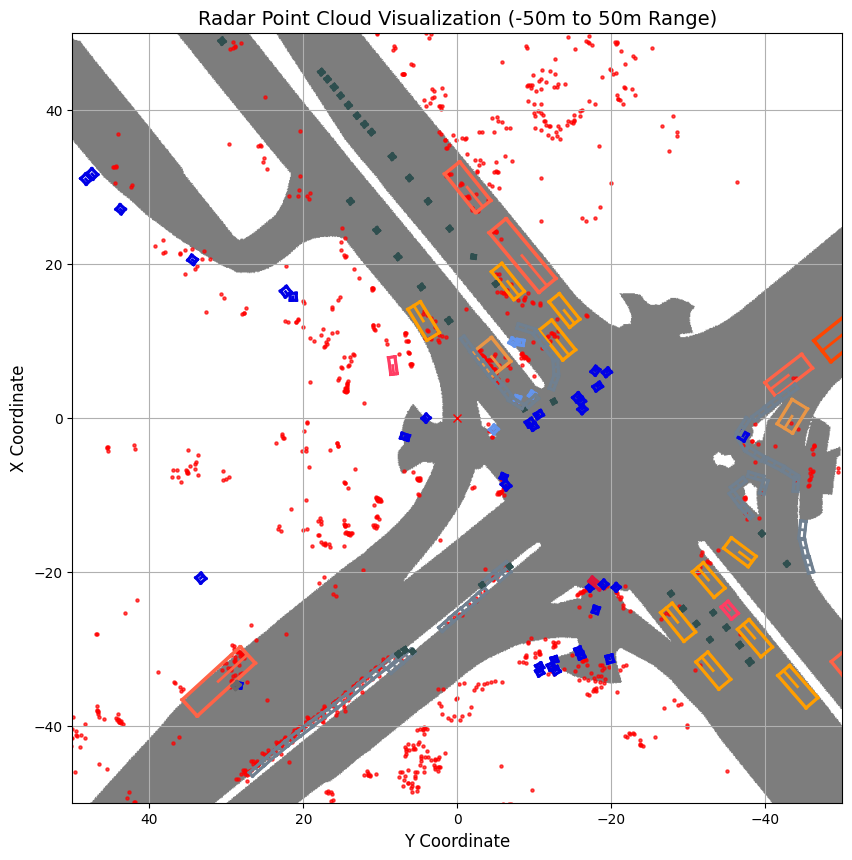

In [17]:
x_coords = points[:, 0]
y_coords = points[:, 1]

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_coords, x_coords, s=5, alpha=0.7, color='red')
ax.set_title("Radar Point Cloud Visualization (-50m to 50m Range)", fontsize=14)
ax.set_xlabel("Y Coordinate", fontsize=12)
ax.set_ylabel("X Coordinate", fontsize=12)
ax.set_xlim(50, -50)  # ISO coordinate
ax.set_ylim(-50, 50)  # ISO coordinate
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
ax.plot(0, 0, 'x', color='red')
ax.imshow(ego_centric_map, extent=[axes_limit, -axes_limit, axes_limit, -axes_limit],
            cmap='gray', vmin=0, vmax=255)

_, boxes = get_sample_data(ref_token)
colormap = get_colormap()
swap_matrix = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
for box in boxes:
    c = np.array(colormap[box.name]) / 255.0
    box.render(ax, view=swap_matrix, colors=(c, c, c))

plt.show()